In [1]:
version = 'v20250521'

import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np

# params
prop = 'change'
tgt = 'soc_change'
space = 'normal'


# # read in delta modelled by delta model
# pair = pd.read_parquet(f'./metric/pair_predicted.pnt_{version}.pq')
# pair = pair[['id', 'pred_pair', 'pred_std_pair', 'pred_change', 'noise', 'snr','time_pair','lc_survey_pair']]
# pair = pair.rename(columns={'pred_change':'pred_change_pnt', 'noise':'noise_pnt', 'snr':'snr_pnt'})
# pair['time_str'] = pair['time_pair'].str[0].astype(str)+'_'+pair['time_pair'].str[1].astype(str)

# # merge delta predicted by delta model and carbon model
# test = pd.read_parquet(f'./metric/pair_predicted.pair_{version}.pq')
# test = test[test.columns[0:12].tolist()+['soc_change','pred','pred_std']]
# test['time_str'] = test['time_pair'].str[0].astype(str)+'_'+test['time_pair'].str[1].astype(str)

# test = test.merge(pair, how='left', on=['id','time_str'])
# test.to_parquet(f'./metric/pair_predicted_{version}.pq')

## Compare $\hat{\delta}$ uncertainty at site level

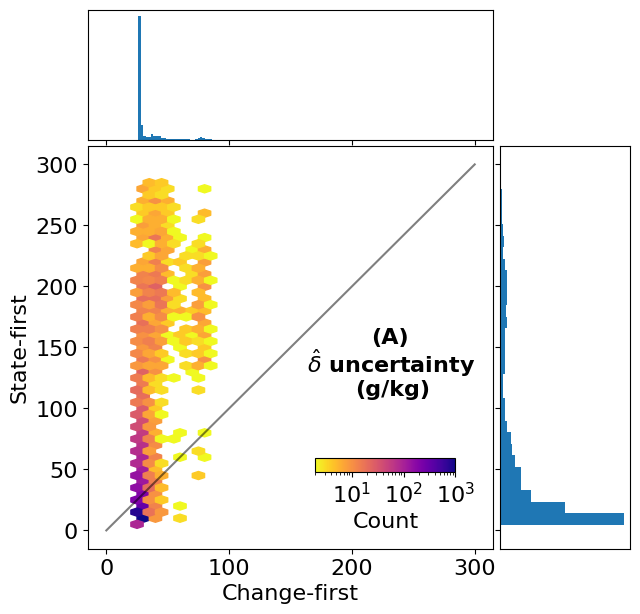

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

test = pd.read_parquet(f'./metric/pair_predicted_{version}.pq')


plt.rcParams.update({'font.size': 16})

# ---- figure & layout --------------------------------------------------------
fig = plt.figure(figsize=(7, 7))
gs  = gridspec.GridSpec(
        4, 4,                       # 4×4 grid
        hspace=0.05, wspace=0.05,   # tight spacing
)

ax_hex   = fig.add_subplot(gs[1:, :-1])  # main hexbin (rows 1-3, cols 0-2)
ax_xhist = fig.add_subplot(gs[0, :-1], sharex=ax_hex)  # top histogram
ax_yhist = fig.add_subplot(gs[1:, -1], sharey=ax_hex)  # right histogram

# ---- main hexbin ------------------------------------------------------------
show_range = [0, 300]
hb = ax_hex.hexbin(
        test['pred_std'], test['noise_pnt'],
        gridsize=(30, 30),
        extent=[*show_range, *show_range],
        cmap='plasma_r', mincnt=2, vmax=1000, bins='log'
)
ax_hex.plot(show_range, show_range, "-k", alpha=0.5)
ax_hex.set_xlabel('Change-first')
ax_hex.set_ylabel('State-first')
ax_hex.text(0.70, 0.55, '(A)', transform=ax_hex.transAxes,fontweight='bold', va='top')
ax_hex.text(0.54, 0.50, r'$\hat{\delta}$ uncertainty', transform=ax_hex.transAxes,fontweight='bold', va='top')
ax_hex.text(0.66, 0.42, r'(g/kg)', transform=ax_hex.transAxes,fontweight='bold', va='top')


# colour-bar
cbar_ax = fig.add_axes([0.45, 0.22, 0.2, 0.02])
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal')
cb.set_label('Count')

# ---- marginal histograms ----------------------------------------------------
bins = 30
ax_xhist.hist(test['pred_std'].dropna(), bins=bins, density=True, edgecolor='none')
ax_yhist.hist(test['noise_pnt'].dropna(), bins=bins, density=True,orientation='horizontal', edgecolor='none')
ax_xhist.tick_params(axis='y', which='both', left=False, labelleft=False)
ax_yhist.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

ax_xhist.tick_params(axis='x', labelbottom=False)
ax_yhist.tick_params(axis='y', labelleft=False)

plt.savefig(f'./figure/plot_mdl.compare_noise.{prop}.svg', bbox_inches='tight')
plt.show()


## Compare $\hat{\beta}$ uncertainty at site level

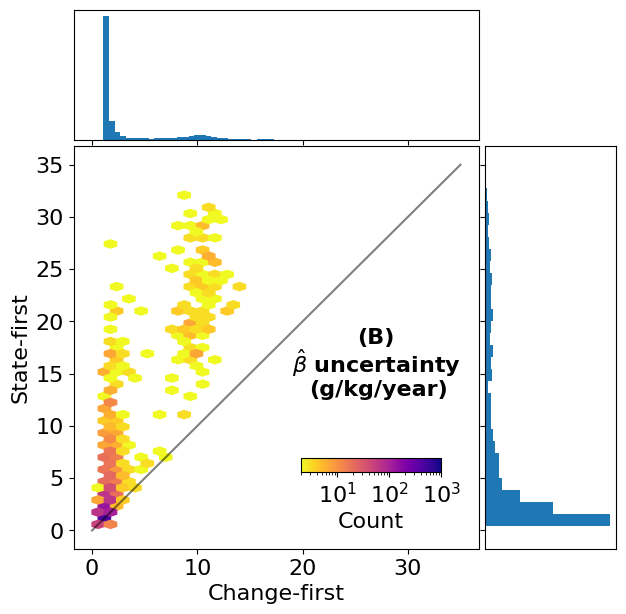

In [3]:
test = pd.read_parquet(f'./metric/srs_predicted_{version}.pq')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams.update({'font.size': 16})

# ---- figure & layout --------------------------------------------------------
fig = plt.figure(figsize=(7, 7))
gs  = gridspec.GridSpec(
        4, 4,                       # 4×4 grid
        hspace=0.05, wspace=0.05,   # tight spacing
)

ax_hex   = fig.add_subplot(gs[1:, :-1])  # main hexbin (rows 1-3, cols 0-2)
ax_xhist = fig.add_subplot(gs[0, :-1], sharex=ax_hex)  # top histogram
ax_yhist = fig.add_subplot(gs[1:, -1], sharey=ax_hex)  # right histogram

# ---- main hexbin ------------------------------------------------------------
show_range = [0, 35]
hb = ax_hex.hexbin(
        test['pred_std'], test['slope_std'],
        gridsize=(30, 30),
        extent=[*show_range, *show_range],
        cmap='plasma_r', mincnt=2, vmax=1000, bins='log'
)
ax_hex.plot(show_range, show_range, "-k", alpha=0.5)
ax_hex.set_xlabel('Change-first')
ax_hex.set_ylabel('State-first')
ax_hex.text(0.70, 0.55, '(B)', transform=ax_hex.transAxes,fontweight='bold', va='top')
ax_hex.text(0.54, 0.50, r'$\hat{\beta}$ uncertainty', transform=ax_hex.transAxes,fontweight='bold', va='top')
ax_hex.text(0.58, 0.42, r'(g/kg/year)', transform=ax_hex.transAxes,fontweight='bold', va='top')

# colour-bar
cbar_ax = fig.add_axes([0.45, 0.22, 0.2, 0.02])
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal')
cb.set_label('Count')

# ---- marginal histograms ----------------------------------------------------
bins = 30
ax_xhist.hist(test['pred_std'].dropna(), bins=bins, density=True, edgecolor='none')
ax_yhist.hist(test['slope_std'].dropna(), bins=bins, density=True,orientation='horizontal', edgecolor='none')
ax_xhist.tick_params(axis='y', which='both', left=False, labelleft=False)
ax_yhist.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

ax_xhist.tick_params(axis='x', labelbottom=False)
ax_yhist.tick_params(axis='y', labelleft=False)

plt.savefig(f'./figure/plot_mdl.compare_noise.{prop}.svg', bbox_inches='tight')
plt.show()


## Result analysis

These two figures compare the uncertainties of $\hat{\delta}$ (A) and $\hat{\beta}$ (B) estimated using two approaches: state-first (y-axis) and change-first (x-axis). Marginal histograms show the distribution of uncertainties from each approach along the top and right axes, respectively.

The state-first approach yields uncertainty estimates with both higher mean and greater spread for both $\hat{\delta}$ and $\hat{\beta}$ compared to the change-first approach. 

Notably, however, the lower end of the uncertainty distribution from the change-first approach tends to be higher than that of the state-first approach, especially for $\hat{\delta}$ prediction. 

For both $\hat{\delta}$ and $\hat{\beta}$, even the minimum uncertainties exceed the typical values of these variables, which are close to zero because SOC changes slowly.
